In [14]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### For a data studio project, I looked at Boston Police Department disciplinary records from 2011-2021. It's well known the Department has an accountability problem, and I wanted to create visualizations to examine this from a new angle. I wanted to know, are officers who are consistently refferred to internal affairs and found guilty less likely to receive a promotion over the course of their career? But this is hard to work out with visuals! Most of the work was doing calculations so I knew my conclusions were solid and then making charts that had more aesthetic than informative value.



### I found that the answer was not really. The proportions of officers getting one, two, three, or even more promotions was essentially the same for groups with any number of allegations and any number of guilty verdicts. At least, it ~looked~ like that was the case. But maybe the one or two percentage point differences were meaningful. To investigate, I'll use an ANOVA test because there are several distributions that need to be investigated (one for each possible number of allegations/guilty findings). I'm treating them as categorical because in practice, officers tend to 

### The null hypotheses here are that for each group composed of officers with a specific number of promotions, the distributions of allegations are the same and the distributions of sustained allegations are the same. The alternative hypothesis would be that the distribution of promotions is different for at least one number of promotions.

In [15]:
df = pd.read_csv('bpd.csv')
df.head()

,name,department_name,title,regular,retro,other,overtime,injured,detail,quinn,total_earnings,zip,year,allegations,sustained,promotion
0,abascianojoseph,Boston Police Department,Police Officer,$68181.24,$0.00,$3763.50,$14177.65,$0.00,$4867.00,$0.00,90989.39,02132-3802,2011,2,0,0
1,abascianojoseph,Boston Police Department,Police Officer,$69432.97,$0.00,$800.00,$16767.14,$0.00,$1767.00,$0.00,88767.11,02132-3802,2012,0,0,0
2,abascianojoseph,Boston Police Department,Police Officer,$66673.45,$0.00,$800.00,$20318.50,$3163.30,$890.00,$0.00,91845.25,02132-3802,2013,1,0,0
3,abascianojoseph,Boston Police Department,Police Officer,$19469.90,$10200.36,$1491.24,$2565.64,$60753.78,$2553.00,$825.04,97858.96,02132,2014,0,0,0
4,abascianojoseph,Boston Police Department,Police Officer,$-886.20,$0.00,$8088.35,$544.83,$81996.78,$0.00,$20667.80,110411.56,02132,2015,0,0,0


In [16]:
# Putting the data we care about into a separate dataframe

names = df.name.unique()
allegations = df.groupby('name').allegations.sum().values
promotions = df.groupby('name').promotion.sum().values
sustained = df.groupby('name').sustained.sum().values

summary_df = pd.DataFrame({'name': names, 'allegations': allegations, 'promotions': promotions, 'sustained': sustained})
summary_df.head()

,name,allegations,promotions,sustained
0,abascianojoseph,4,0,0
1,abdul-azizramadani,2,0,2
2,abreucesar,4,0,0
3,acerichardk,15,1,7
4,acevedorafaelw,0,0,0


In [30]:
%%R -i summary_df

# First ANOVA

summary(aov(sustained ~ promotions, data = summary_df))



              Df Sum Sq Mean Sq F value Pr(>F)
promotions     1      0   0.214   0.045  0.831
Residuals   3277  15430   4.709               


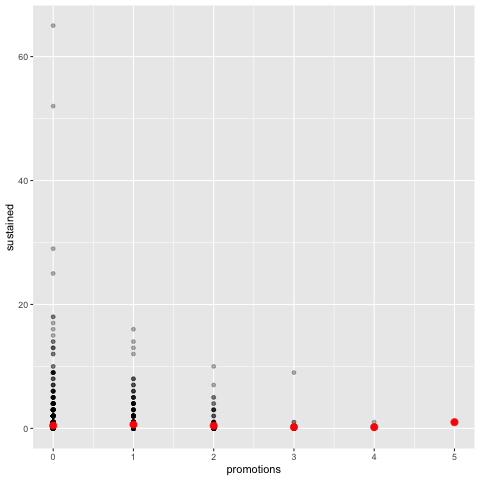

In [31]:
%%R -i summary_df

library(ggplot2)
library(dplyr)

#Plotting the data

ggplot(summary_df, aes(x = promotions, y = sustained)) + geom_point(alpha = 0.3) +
geom_point(data = summary_df %>% group_by(promotions) %>% summarise(sustained = mean(sustained)), size = 3, color = 'red') 

In [32]:
%%R -i summary_df

# Second ANOVA
summary(aov(allegations ~ promotions, data = summary_df))

              Df Sum Sq Mean Sq F value   Pr(>F)    
promotions     1    304   304.4   25.37 4.99e-07 ***
Residuals   3277  39327    12.0                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


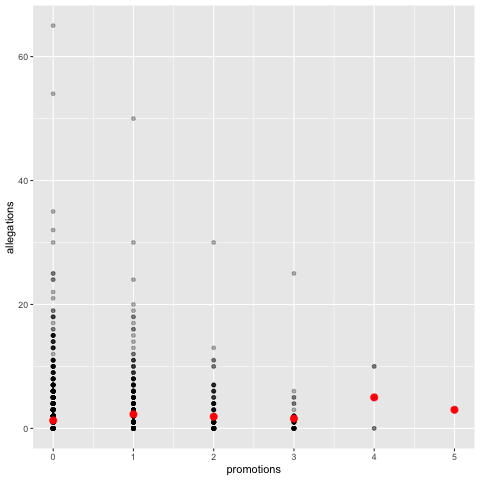

In [33]:
%%R -i summary_df

library(ggplot2)
library(dplyr)

#Plotting the data

ggplot(summary_df, aes(x = promotions, y = allegations)) + geom_point(alpha = 0.3) +
geom_point(data = summary_df %>% group_by(promotions) %>% summarise(allegations = mean(allegations)), size = 3, color = 'red') 

### So! Looks like the null hypothesis for sustained allegations can't be rejected. But at least one number of promotions an officer received corresponds to its own distribution of allegations.

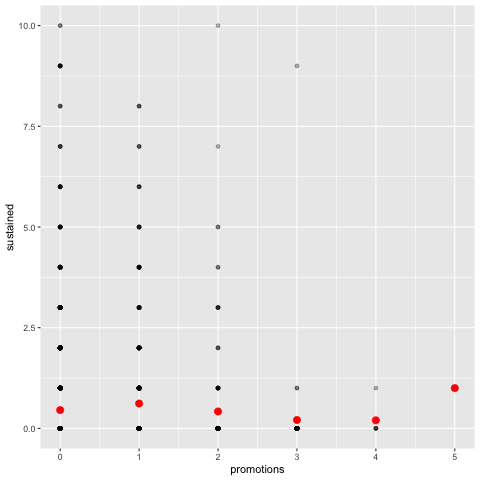

In [21]:
%%R -i summary_df

# Zooming in

library(ggplot2)
library(dplyr)

ggplot(summary_df, aes(x = promotions, y = sustained)) + geom_point(alpha = 0.3) +
geom_point(data = summary_df %>% group_by(promotions) %>% summarise(sustained = mean(sustained)), size = 3, color = 'red') +
ylim(0, 10)

### It's not super clear which one (or ones) of these is different, so I'll use a Tukey HSD test.

In [ ]:
%%R -i summary_df

TukeyHSD(aov(allegations ~ factor(promotions), data = summary_df))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = allegations ~ factor(promotions), data = summary_df)

$`factor(promotions)`
          diff         lwr        upr     p adj
1-0  0.9864884   0.5333055  1.4396713 0.0000000
2-0  0.5980991  -0.2176781  1.4138763 0.2923838
3-0  0.2991338  -1.0686898  1.6669573 0.9893223
4-0  3.7142281  -0.6967029  8.1251592 0.1560508
5-0  1.7142281  -8.1409753 11.5694316 0.9963266
2-1 -0.3883893  -1.2786722  0.5018936 0.8151079
3-1 -0.6873546  -2.1008795  0.7261702 0.7352339
4-1  2.7277397  -1.6975765  7.1530560 0.4936127
5-1  0.7277397  -9.1339106 10.5893900 0.9999436
3-2 -0.2989653  -1.8668206  1.2688900 0.9943394
4-2  3.1161290  -1.3608724  7.5931304 0.3513012
5-2  1.1161290  -8.7688224 11.0010804 0.9995421
4-3  3.4150943  -1.1945684  8.0247570 0.2809231
5-3  1.4150943  -8.5306441 11.3608328 0.9985934
5-4 -2.0000000 -12.7936595  8.7936595 0.9950512



### The difference between the mean allegations of officers with one promotion and those with no promotions is significant. I'll use a t test to interrogate that further

In [27]:
promotions0 = summary_df[summary_df.promotions == 0]
promotions1 = summary_df[summary_df.promotions == 1]
promotions2 = summary_df[summary_df.promotions == 2]
promotions3 = summary_df[summary_df.promotions == 3]
promotions4 = summary_df[summary_df.promotions == 4]

In [34]:
%%R -i promotions0 -i promotions1

t.test(promotions0$allegations, promotions1$allegations)



	Welch Two Sample t-test

data:  promotions0$allegations and promotions1$allegations
t = -5.6043, df = 790.8, p-value = 2.888e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.3320163 -0.6409606
sample estimates:
mean of x mean of y 
 1.285772  2.272260 



### So, the mean number of allegations for officers with one promotion is about one allegation more than those with no promotions, and this is statistically significant. I hesitate to use a regression, because this is more categorical than continuous data, but I'm curious what the R-squared is. 

In [42]:
test_df = summary_df[summary_df.promotions < 2]

`geom_smooth()` using formula = 'y ~ x'


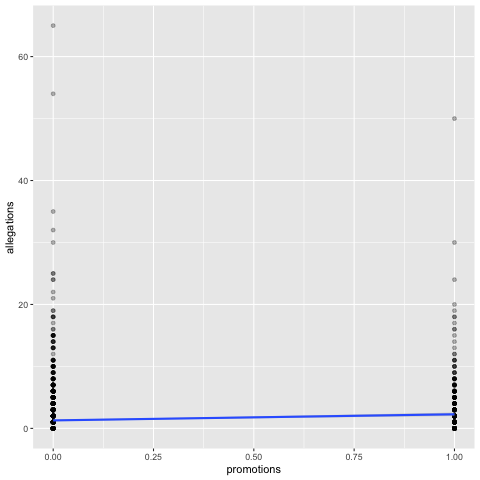

In [43]:
%%R -i test_df

# plotting a linear model

ggplot(test_df, aes(x = promotions, y = allegations)) + geom_point(alpha = 0.3) +
geom_smooth(method = 'lm')

In [44]:
%%R -i test_df

summary(lm(allegations ~ promotions, data = summary_df))


Call:
lm(formula = allegations ~ promotions, data = summary_df)

Residuals:
   Min     1Q Median     3Q    Max 
-3.194 -1.349 -1.349  0.190 63.651 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.34916    0.06757  19.966  < 2e-16 ***
promotions   0.46115    0.09156   5.037 4.99e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.464 on 3277 degrees of freedom
Multiple R-squared:  0.007682,	Adjusted R-squared:  0.007379 
F-statistic: 25.37 on 1 and 3277 DF,  p-value: 4.994e-07



### So the R-squared is small, meaning that while the average means are significantly different for the two groups, an officers number of promotions doesn't explain a lot of the variance in the allegation distribution.

### Going back to journalistic inquiry, I think it's interesting that there isn't statistical evidence that the BPD's promotion practices weed out officers who the Department itself finds guilty of misconduct. It would be interesting to request copies of the criteria they use to promote officers.

### As far as the significant difference in allegations between officers with one and no promotions, I'm thinking that has something to do with an officer's time on the force: the longer you're around, the more likely you are to both be promoted and be accused of misconduct. But, the R-squared is so low it's probably not worth further inquiry.

### I'd like to figure out a way to control for things like someone's time on the force when doing this, but I think that's coming up tomorrow, lol.